In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
t = np.load('idxs.npy', allow_pickle=True)[1]
df = pd.read_csv('attention.csv.gz', index_col=0, low_memory=False)
df.index = t
df.columns = t
drug = df[:269]
drug_gene = drug.iloc[:, 329:]

In [3]:
print(drug_gene[(drug_gene['TOP1'] != 0) | (drug_gene['TOP1MT'] != 0) | (drug_gene['TOP2A'] != 0) | (drug_gene['TOP2B'] != 0)].shape)
print(drug_gene[(drug_gene['TOP1'] != 0) | (drug_gene['TOP2A'] != 0) | (drug_gene['TOP2B'] != 0)].shape)
print(drug_gene[(drug_gene['TOP1'] != 0) ].shape)
print(drug_gene[(drug_gene['TOP2A'] != 0) | (drug_gene['TOP2B'] != 0) ].shape)

(206, 2718)
(206, 2718)
(184, 2718)
(196, 2718)


In [4]:
print(drug_gene[(drug_gene['TOP1'] > (1/drug_gene.shape[1])*10) | (drug_gene['TOP1MT'] > (1/drug_gene.shape[1])*10) | (drug_gene['TOP2A'] > (1/drug_gene.shape[1])*10) | (drug_gene['TOP2B'] > (1/drug_gene.shape[1])*10)].shape)
print(drug_gene[(drug_gene['TOP1'] > (1/drug_gene.shape[1])*10) | (drug_gene['TOP2A'] > (1/drug_gene.shape[1])*10) | (drug_gene['TOP2B'] > (1/drug_gene.shape[1])*10)].shape)
print(drug_gene[(drug_gene['TOP1'] > (1/drug_gene.shape[1])*10) ].shape)
print(drug_gene[(drug_gene['TOP2A'] > (1/drug_gene.shape[1])*10) | (drug_gene['TOP2B'] > (1/drug_gene.shape[1])*10) ].shape)

(206, 2718)
(206, 2718)
(184, 2718)
(196, 2718)


In [5]:
drug_gene[(drug_gene['TOP1'] != 0)]

,A2M,AAK1,ABCB1,ABL1,ABL2,ABRACL,ACAT1,ACKR3,ACLY,ACO2,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
752,0.003608,0.004824,0.003581,0.004963,0.004949,0.003423,0.003373,0.003529,0.003250,0.003382,...,0.003327,0.003505,0.003340,0.003308,0.003361,0.003338,0.003412,0.003434,0.003295,0.003294
762,0.003530,0.004777,0.003577,0.004939,0.004880,0.003393,0.003360,0.003474,0.003244,0.003318,...,0.003330,0.003448,0.003285,0.003300,0.003380,0.003285,0.003378,0.003418,0.003271,0.003272
3053,0.003605,0.000000,0.003633,0.000000,0.000000,0.003449,0.003422,0.003569,0.003284,0.003387,...,0.003376,0.003529,0.003361,0.003332,0.003430,0.003348,0.003420,0.003480,0.003339,0.003318
3088,0.003578,0.004739,0.003597,0.004903,0.004845,0.003384,0.003325,0.003470,0.003230,0.003295,...,0.003306,0.003425,0.003298,0.003289,0.003372,0.003316,0.003353,0.003407,0.003277,0.003259
6396,0.003552,0.004747,0.003575,0.004885,0.004852,0.003408,0.003346,0.003492,0.003216,0.003301,...,0.003309,0.003429,0.003280,0.003254,0.003368,0.003315,0.003328,0.003425,0.003289,0.003230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765775,0.003642,0.004829,0.003688,0.004987,0.004950,0.003462,0.003424,0.003596,0.003291,0.003405,...,0.003388,0.003542,0.003366,0.003360,0.003448,0.003368,0.003429,0.003511,0.003347,0.003328
768112,0.003731,0.004924,0.003693,0.005091,0.005026,0.003484,0.003468,0.003602,0.003331,0.003447,...,0.003405,0.003571,0.003415,0.003389,0.003501,0.003386,0.003529,0.003557,0.003382,0.003369
768593,0.003574,0.004789,0.003594,0.004935,0.004879,0.003424,0.003393,0.003556,0.003233,0.003339,...,0.003339,0.003487,0.003316,0.003304,0.003380,0.003308,0.003365,0.003436,0.003320,0.003274
789797,0.003532,0.004745,0.003518,0.004916,0.004857,0.003357,0.003336,0.003449,0.003204,0.003296,...,0.003284,0.003394,0.003263,0.003237,0.003327,0.003261,0.003307,0.003368,0.003253,0.003222


In [6]:
name = dict(pd.read_csv(
    'nsc_cid_smiles_class_name.csv', 
    index_col=0)[['NSC', 'NAME']].values)

In [7]:
drug_gene.index = [name[i] for i in drug_gene.index]
drug_gene

,A2M,AAK1,ABCB1,ABL1,ABL2,ABRACL,ACAT1,ACKR3,ACLY,ACO2,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
Methotrexate,0.003684,0.000000,0.003669,0.000000,0.000000,0.003496,0.003454,0.003605,0.003355,0.003446,...,0.003412,0.003558,0.003408,0.003410,0.003498,0.003412,0.003494,0.003540,0.003394,0.003387
Thioguanine,0.003608,0.004824,0.003581,0.004963,0.004949,0.003423,0.003373,0.003529,0.003250,0.003382,...,0.003327,0.003505,0.003340,0.003308,0.003361,0.003338,0.003412,0.003434,0.003295,0.003294
Mercaptopurine,0.003530,0.000000,0.003582,0.000000,0.000000,0.003360,0.003335,0.003479,0.003221,0.003301,...,0.003307,0.003430,0.003286,0.003286,0.003371,0.003272,0.003372,0.003386,0.003289,0.003258
Mechlorethamine hydrochloride,0.003530,0.004777,0.003577,0.004939,0.004880,0.003393,0.003360,0.003474,0.003244,0.003318,...,0.003330,0.003448,0.003285,0.003300,0.003380,0.003285,0.003378,0.003418,0.003271,0.003272
Allopurinol,0.003637,0.000000,0.003649,0.000000,0.000000,0.003456,0.003425,0.003601,0.003295,0.003382,...,0.003382,0.003535,0.003351,0.003374,0.003419,0.003370,0.003442,0.003498,0.003341,0.003323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[6-[[5-Fluoro-2-(3,4,5-trimethoxyanilino)pyrimidin-4-yl]amino]-2,2-dimethyl-3-oxopyrido[3,2-b][1,4]oxazin-4-yl]methyl phosphate",0.003556,0.000000,0.003533,0.000000,0.000000,0.003360,0.003360,0.003477,0.003229,0.003312,...,0.003313,0.003437,0.003282,0.003307,0.003352,0.003297,0.003363,0.003401,0.003251,0.003257
"3H-Pyridazino[3,4,5-de]quinazolin-3-one, 8-[(1,3-dihydro-2H-isoindol-2-yl)methyl]-1,2-dihydro-",0.003630,0.004834,0.003642,0.004972,0.004920,0.003450,0.003415,0.003566,0.003282,0.003380,...,0.003364,0.003489,0.003333,0.003337,0.003427,0.003352,0.003422,0.003481,0.003323,0.003296
Aldoxorubicin,0.003471,0.000000,0.003424,0.000000,0.000000,0.003279,0.003245,0.003355,0.003149,0.003245,...,0.003215,0.003329,0.003229,0.003203,0.003280,0.003220,0.003269,0.003314,0.003185,0.003187
"2-(5-ethyl-5H-[1,2,4]triazino[5,6-b]indol-3-ylthio)-N-(2-methoxyphenyl)butanamide",0.003532,0.004745,0.003518,0.004916,0.004857,0.003357,0.003336,0.003449,0.003204,0.003296,...,0.003284,0.003394,0.003263,0.003237,0.003327,0.003261,0.003307,0.003368,0.003253,0.003222


In [8]:
drug_gene[drug_gene.index.str.contains('cin')].index

Index(['Dactinomycin D', 'Mitramycin', 'mitomycin C', 'Porfiromycine',
       'Ellipticine', 'Camptothecin', 'Camptothecin, acetate',
       'Camptothecine sodium', 'Deoxycamptothecin', '10-Hydroxycamptothecin',
       '10-Methoxycamptothecin', 'Mitomycin C, K-35 deriv.', 'Acivicin',
       'Zorubicin hydrochloride', '9-Methoxycamptothecin', 'Chlorozotocin',
       'N-Trifluoroacetyladriamycin-14-valerate', '7-Chlorocamptothecin',
       '4'-Deoxydoxorubicin hydrochloride',
       'N,N-Dibenzyldaunorubicin hydrochloride', 'Bleomycin pep-CU (formerly)',
       '(+)-Camptothecin', 'Aphidicolin glycinate, hydrochloride',
       '8,9-Dimethoxycamptothecin', '2-Methylellipticinium iodide',
       '2-Methylellipticinium methanesulfonate', 'Morpholinoadriamycin',
       'Camptothecin,N-diethyl) glycinate', 'Camptothecin, 10-amino-',
       'Camptothecin,20-O-((4-(2-hydroxyethyl)-1-piperazino)oac',
       '9-Aminocamptothecin', '9-Nitro-10-methoxy-20(S)-camptothecin',
       '10-Hydroxy-9-nitr

In [9]:
drug_gene[drug_gene.index.str.contains('can')]

,A2M,AAK1,ABCB1,ABL1,ABL2,ABRACL,ACAT1,ACKR3,ACLY,ACO2,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
Topotecan hydrochloride,0.003479,0.000000,0.003479,0.000000,0.000000,0.003348,0.003312,0.003417,0.003204,0.003289,...,0.003285,0.003361,0.003261,0.003261,0.003313,0.003253,0.003303,0.003339,0.003222,0.003225
Irinotecan hydrochloride,0.003711,0.000000,0.003770,0.000000,0.000000,0.003477,0.003476,0.003603,0.003313,0.003416,...,0.003404,0.003545,0.003377,0.003334,0.003489,0.003393,0.003516,0.003536,0.003368,0.003358
Silatecan,0.003549,0.004746,0.003535,0.004888,0.004859,0.003375,0.003343,0.003490,0.003220,0.003301,...,0.003289,0.003427,0.003272,0.003290,0.003347,0.003285,0.003349,0.003402,0.003273,0.003249
Indotecan,0.003448,0.004713,0.003449,0.004829,0.004800,0.003287,0.003268,0.003379,0.003159,0.003228,...,0.003241,0.003328,0.003200,0.003213,0.003241,0.003216,0.003226,0.003286,0.003183,0.003171
Indimitecan hydrochloride,0.003637,0.004886,0.003660,0.005042,0.004971,0.003448,0.003445,0.003574,0.003303,0.003406,...,0.003378,0.003517,0.003351,0.003338,0.003450,0.003359,0.003472,0.003511,0.003342,0.003341
Irinotecan,0.003526,0.000000,0.003572,0.000000,0.000000,0.003391,0.003370,0.003486,0.003230,0.003330,...,0.003324,0.003437,0.003276,0.003286,0.003376,0.003309,0.003367,0.003414,0.003283,0.003261
"2-Amino-4,6-dimethyl-3-oxophenoxazine-1,9-dicarboxylic acid bis[1-[10,13-dimethyl-2,5,8,11,14-pentaoxo-3,9-di(propan-2-yl)-1,4,7,10,13-pentazabicyclo[13.3.0]octadecan-6-yl]ethyl] ester",0.003597,0.004708,0.003577,0.004848,0.004838,0.003387,0.003302,0.003488,0.003209,0.003278,...,0.003292,0.003431,0.003278,0.003278,0.003336,0.003322,0.003316,0.003401,0.003259,0.003245
Topotecan hydrochloride,0.003550,0.000000,0.003601,0.000000,0.000000,0.003392,0.003386,0.003493,0.003239,0.003326,...,0.003341,0.003440,0.003288,0.003286,0.003378,0.003317,0.003364,0.003429,0.003309,0.003278
Irinotecan hydrochloride,0.003703,0.000000,0.003712,0.000000,0.000000,0.003513,0.003483,0.003684,0.003328,0.003425,...,0.003427,0.003624,0.003378,0.003379,0.003459,0.003427,0.003493,0.003545,0.003362,0.003387


In [10]:
graph = pd.DataFrame()
for i in [
#     'Deoxycamptothecin', 
    'Irinotecan', 'Topotecan hydrochloride', 'Mercaptopurine', 
    'Allopurinol', 'Camptothecin', 'Daunorubicin', 'Aldoxorubicin'
    ]:
    tmp = (drug_gene.loc[i])
    if tmp.shape[0] > 10:
        tmp = tmp.sort_values(ascending=False)[:5]
    else:
        tmp = tmp.iloc[1].sort_values(ascending=False)[:5]
    
    tmp = pd.DataFrame(tmp)
    tmp['name'] = list(tmp.columns)*5
    tmp = tmp.reset_index()
    tmp.columns = ['genes', 'Attention', 'name']
    graph = pd.concat([graph, tmp])
    
graph['name'] = graph['name'].str.replace(' hydrochloride', '')
graph = graph.reset_index(drop=True)

In [11]:
graph

,genes,Attention,name
0,TOP1MT,0.004951,Irinotecan
1,TOP1,0.004766,Irinotecan
2,MIR6807,0.003672,Irinotecan
3,MPO,0.003669,Irinotecan
4,KRT14,0.003661,Irinotecan
5,TOP1MT,0.004957,Topotecan
6,TOP1,0.004772,Topotecan
7,MIR2278,0.003691,Topotecan
8,MIR6728,0.003681,Topotecan
9,MMP3,0.003680,Topotecan


In [12]:
graph.to_csv('graph.csv')

In [13]:
dti = pd.read_csv('../../drugbank_xml2csv_python/dti_drugbank.csv', index_col=0)
dti.index = [name[i] for i in dti.index]
dti = dti.loc[dti.index.isin(set(graph.name)), dti.columns.isin(set(graph.genes))].drop_duplicates()

In [14]:
dtis = pd.DataFrame()
for i in dti.index:
    tmp = dti.loc[i].reset_index()
    tmp['drug'] = [i]*len(tmp)
    tmp = tmp[tmp[i] == 1]
    tmp.columns = ['genes', 'dtis', 'name']
    dtis = pd.concat([dtis, tmp])

In [15]:
dtis = pd.concat([dtis, pd.DataFrame([
    ['TOP1', 1, 'Topotecan'],
    ['TOP1MT', 1, 'Topotecan']
], columns=dtis.columns)])
dtis

,genes,dtis,name
0,HPRT1,1,Mercaptopurine
1,IMPDH1,1,Mercaptopurine
2,PPAT,1,Mercaptopurine
7,XDH,1,Allopurinol
3,TOP1,1,Camptothecin
3,TOP1,1,Irinotecan
4,TOP1MT,1,Irinotecan
5,TOP2A,1,Daunorubicin
6,TOP2B,1,Daunorubicin
5,TOP2A,1,Aldoxorubicin


In [16]:
graph = graph.merge(dtis, how='left').fillna(0)
graph

,genes,Attention,name,dtis
0,TOP1MT,0.004951,Irinotecan,1.0
1,TOP1,0.004766,Irinotecan,1.0
2,MIR6807,0.003672,Irinotecan,0.0
3,MPO,0.003669,Irinotecan,0.0
4,KRT14,0.003661,Irinotecan,0.0
5,TOP1MT,0.004957,Topotecan,1.0
6,TOP1,0.004772,Topotecan,1.0
7,MIR2278,0.003691,Topotecan,0.0
8,MIR6728,0.003681,Topotecan,0.0
9,MMP3,0.003680,Topotecan,0.0


In [17]:
weights_list = []
for i in set(graph.name):
    t = graph[graph.name == i]
    max_weight, min_weight = max(t['Attention']), min(t['Attention'])
    # (weight - min_weight) / (max_weight - min_weight)
    weights_list.extend(list((t['Attention'] - min_weight)/(max_weight - min_weight)))

In [18]:
df = graph.copy()
df['Attention'] = weights_list
df

,genes,Attention,name,dtis
0,TOP1MT,1.000000,Irinotecan,1.0
1,TOP1,0.856443,Irinotecan,1.0
2,MIR6807,0.008951,Irinotecan,0.0
3,MPO,0.005906,Irinotecan,0.0
4,KRT14,0.000000,Irinotecan,0.0
5,TOP1MT,1.000000,Topotecan,1.0
6,TOP1,0.854636,Topotecan,1.0
7,MIR2278,0.009000,Topotecan,0.0
8,MIR6728,0.001181,Topotecan,0.0
9,MMP3,0.000000,Topotecan,0.0


In [19]:
df

,genes,Attention,name,dtis
0,TOP1MT,1.000000,Irinotecan,1.0
1,TOP1,0.856443,Irinotecan,1.0
2,MIR6807,0.008951,Irinotecan,0.0
3,MPO,0.005906,Irinotecan,0.0
4,KRT14,0.000000,Irinotecan,0.0
5,TOP1MT,1.000000,Topotecan,1.0
6,TOP1,0.854636,Topotecan,1.0
7,MIR2278,0.009000,Topotecan,0.0
8,MIR6728,0.001181,Topotecan,0.0
9,MMP3,0.000000,Topotecan,0.0


In [20]:
df.to_csv('graph_norm.csv')

In [21]:
df = pd.read_csv('graph_norm.csv', index_col=0)
df

,genes,Attention,name,dtis
0,TOP1MT,1.000000,Irinotecan,1.0
1,TOP1,0.856443,Irinotecan,1.0
2,MIR6807,0.008951,Irinotecan,0.0
3,MPO,0.005906,Irinotecan,0.0
4,KRT14,0.000000,Irinotecan,0.0
5,TOP1MT,1.000000,Topotecan,1.0
6,TOP1,0.854636,Topotecan,1.0
7,MIR2278,0.009000,Topotecan,0.0
8,MIR6728,0.001181,Topotecan,0.0
9,MMP3,0.000000,Topotecan,0.0


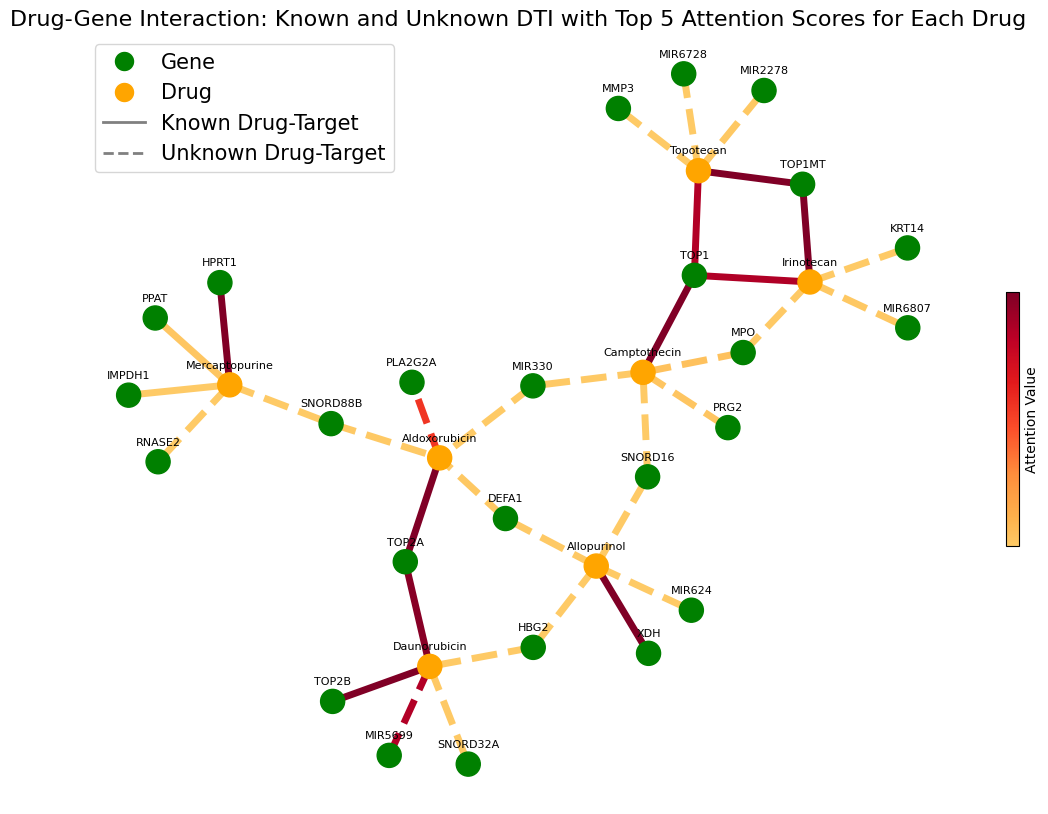

In [43]:
G = nx.from_pandas_edgelist(df, 'genes', 'name', ['Attention', 'dtis'])

# Kamada-Kawai layout for node positioning
pos_kk = nx.kamada_kawai_layout(G)

# Node colors: green for genes, orange for drugs
genes = set(df['genes'])
drugs = set(df['name'])
node_colors = ['green' if node in genes else 'orange' for node in G.nodes()]

# Adjust label positions for clarity
label_pos = {key: [value[0], value[1] + 0.05] for key, value in pos_kk.items()}

# Drawing the graph with attention values mapped to colors using a colormap
edges, weights = zip(*nx.get_edge_attributes(G, 'Attention').items())
edges_dtis, dtis_values = zip(*nx.get_edge_attributes(G, 'dtis').items())

# Creating a color map based on the Attention values
cmap = plt.cm.YlOrRd
cmap_modified = cmap(np.linspace(0.3, 1.0, 256))  # Start from 30% to remove the lightest colors
cmap_modified = plt.cm.colors.ListedColormap(cmap_modified)

# Normalize Attention values for colormap
norm = plt.Normalize(0, max(weights))

fig, ax = plt.subplots(figsize=(14, 10))

# Draw nodes
nx.draw_networkx_nodes(G, pos_kk, node_color=node_colors, node_size=300, ax=ax)

# Draw edges
for edge, weight, dtis in zip(edges, weights, dtis_values):
    nx.draw_networkx_edges(G, pos_kk, edgelist=[edge], width=5,
                           edge_color=cmap_modified(norm(weight)),
                           style='dashed' if dtis == 0 else 'solid',
                           ax=ax)
    
# Draw labels
nx.draw_networkx_labels(G, label_pos, font_size=8, ax=ax)

# Create colorbar as legend for Attention values
sm = plt.cm.ScalarMappable(cmap=cmap_modified, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.33, ticks=[])
cbar.set_label('Attention Value')

# Legend for node colors
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=15, label='Gene')
orange_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=15, label='Drug')

plt.legend(handles=[
        green_patch, orange_patch, 
        plt.Line2D([0], [0], color='gray', lw=2, ls='-', label='Known Drug-Target'),
        plt.Line2D([0], [0], color='gray', lw=2, ls='--', label='Unknown Drug-Target')
    ], 
           loc='upper left', fontsize=15)

plt.axis('off')
plt.title('Drug-Gene Interaction: Known and Unknown DTI with Top 5 Attention Scores for Each Drug', fontsize=16)
plt.show()

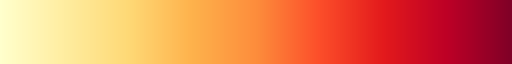

In [37]:
cmap

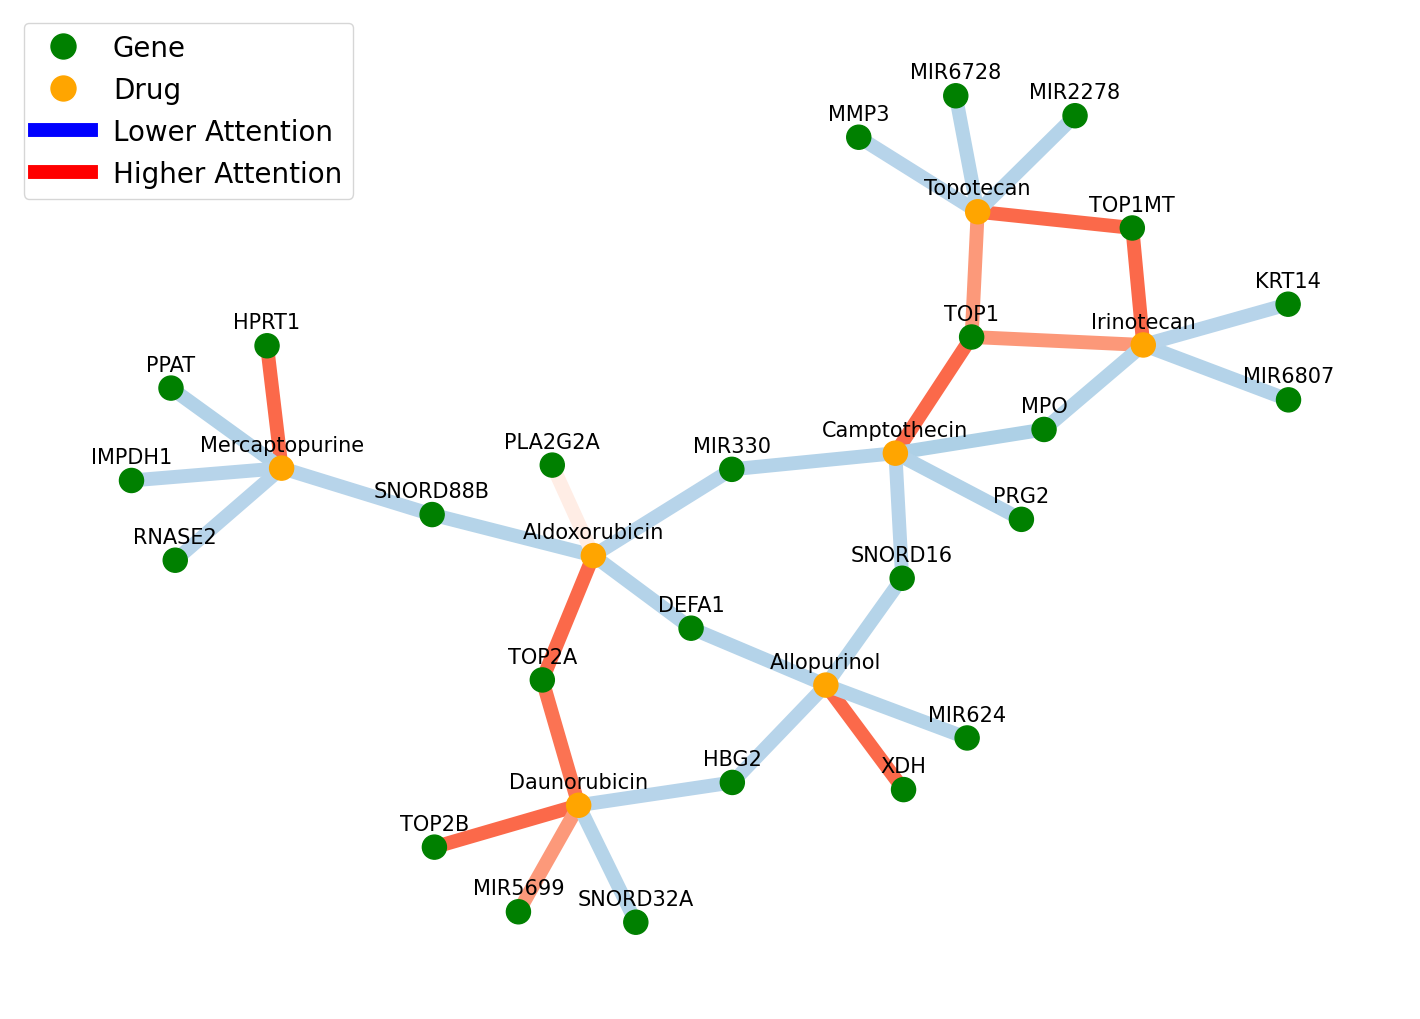

In [23]:
# Create the graph
G = nx.from_pandas_edgelist(df, 'genes', 'name', ['Attention'])

# Identify unique genes and drugs to differentiate their colors
genes = set(df['genes'])
drugs = set(df['name'])

# Kamada-Kawai layout
pos_kk = nx.kamada_kawai_layout(G)

# Node colors: green for genes, orange for drugs
node_colors = ['green' if node in genes else 'orange' for node in G.nodes()]

# Adjust label positions for clarity
label_pos = {key: [value[0], value[1] + 0.05] for key, value in pos_kk.items()}

# Edge colors based on 'Attention' values: grey-blue for lower, red for higher attention
edge_colors_grey_red = [
    plt.cm.Blues(0.3 + 0.7 * weight) if weight < 0.5 else plt.cm.Reds(weight - 0.5) 
    for weight in nx.get_edge_attributes(G, 'Attention').values()
]

# Plotting
plt.figure(figsize=(14, 10))
nx.draw(G, pos_kk, node_size=300, font_size=50, edge_color=edge_colors_grey_red, 
        node_color=node_colors, width=10)
nx.draw_networkx_labels(G, label_pos, font_size=15)

# Legend for node colors
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=20, label='Gene')
orange_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=20, label='Drug')

# Adjusted legend to include edge color significance
plt.legend(handles=[green_patch, orange_patch, 
                    plt.Line2D([0], [0], color='blue', linewidth=10, label='Lower Attention'),
                    plt.Line2D([0], [0], color='red', linewidth=10, label='Higher Attention')], 
           loc='upper left', fontsize=20)

plt.show()